# NLP based - Fake News Classification

## About Dataset

- This dataset has been downloaded from kaggle: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
- Here is the link to lincense: https://creativecommons.org/licenses/by/4.0/

Note: We have already downloaded and decompressed the data in the same directory as notebook

## Importing useful libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
%matplotlib inline

## Reading and Verifying data

In [6]:
news_df = pd.read_csv("WELFake_Dataset.csv")
print(news_df.shape)
news_df.head()

(72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


### NULL value check

In [7]:
news_df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

- Very small number of NULL values
- Let's fill them with empty string value

In [8]:
news_df.fillna('', inplace=True)

#### Creating a new column "content" with combined 'title' and 'text' that we will use for model training and predicitons

In [13]:
news_df['content'] = [x + ' ' + y for x,y in zip(news_df.title, news_df.text)]

### cleaning and pre-processing text data for model:
- remove any speacial characters and numbers from text
- convert the text into lowercase
- split the content by space to get list of words
- remove stopwords: common english words that are often meaningless in a sentence
- apply stemming: reduce words to their root words
- now again join words with spaces in between to create text

In [28]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def clean_and_prepare_content(text):
    text = re.sub('[^a-zA-Z]',' ', text)
    text = text.lower()
    text_words = text.split()
    imp_text_words = [word for word in text_words if not word in stopwords.words('english')]
    stemmed_words = [porter_stemmer.stem(word) for word in imp_text_words]
    processed_text = ' '.join(stemmed_words)
    return processed_text

porter_stemmer = PorterStemmer()
news_df['processed_content'] = news_df.content.apply(lambda content: clean_and_prepare_content(content))

### Separating data and labels into two arrays

In [26]:
X = news_df.processed_content.values
y = news_df.label.values
print(X.shape, y.shape)

(72134,) (72134,)


### Converting textual data to numberic format for model

In [29]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [30]:
print(X.shape)

(72134, 162203)


## Splitting data into train and test

- we will consider 80% data as training and rest 20% as test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

## Defining Random Forest Classifier

In [33]:
rf_model = RandomForestClassifier()

## Training Model

In [34]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

## Predict on test data

In [35]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)

## Checking Results/Metrics on Test data

### classification report

In [36]:
print(
    classification_report(
        y_test,
        y_pred,
        target_names=['Real', 'Fake'],
    )
)

              precision    recall  f1-score   support

        Real       0.94      0.92      0.93      7006
        Fake       0.93      0.94      0.94      7421

    accuracy                           0.93     14427
   macro avg       0.93      0.93      0.93     14427
weighted avg       0.93      0.93      0.93     14427



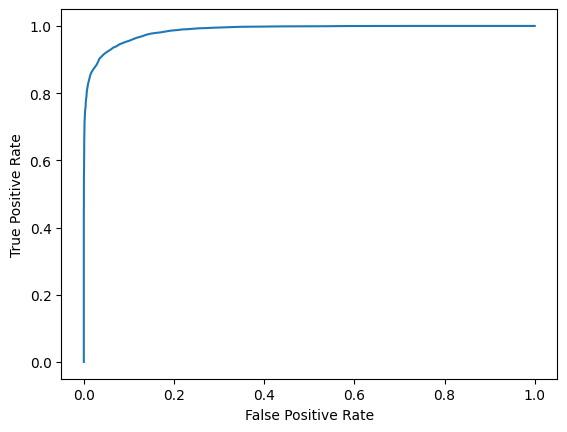

In [43]:
def plot_roc_curve(y_true, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(y_test, y_proba[:,1])

### confusion matrix

In [44]:
confusion_matrix(y_test, y_pred,)

array([[6455,  551],
       [ 409, 7012]])

## Now putting this all together into a Vertex AI custom training JOB

### Here are the steps
- put data table into GCS or BigQuery (we will use GCS)
- create a task.py file that:
    - reads data from GCS
    - does necessary data preparation
    - trains the RF model
    - saves model into GCS
    - does prediciton on test set
    - saves predictions to GCS
- use a pre-built training image 
- launch vertex ai training
- monitor the progress on Google Cloud Console UI

In [47]:
from google.cloud import aiplatform

## Define Necessary Configurations

In [50]:
PROJECT_ID='417812395597'
REGION='us-west2'
BUCKET_URI='gs://my-training-artifacts'
DATA_LOCATION='gs://my-training-artifacts/WELFake_Dataset.csv'

# pre-built training containers
TRAIN_VERSION = "tf-cpu.2-9"
TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)

## Initialize Vertex AI SDK

In [48]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Define task.py files with entire end-to-end code

In [58]:
%%writefile task.py
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from google.cloud import storage

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download("stopwords")

BUCKET='my-training-artifacts'
DATA_LOCATION='gs://my-training-artifacts/WELFake_Dataset.csv'

# loading and preparing data
news_df = pd.read_csv(DATA_LOCATION)
news_df.fillna('', inplace=True)
news_df['content'] = [x + ' ' + y for x,y in zip(news_df.title, news_df.text)]

# cleaning and pre-processing data
def clean_and_prepare_content(text):
    text = re.sub('[^a-zA-Z]',' ', text)
    text = text.lower()
    text_words = text.split()
    imp_text_words = [word for word in text_words if not word in stopwords.words('english')]
    stemmed_words = [porter_stemmer.stem(word) for word in imp_text_words]
    processed_text = ' '.join(stemmed_words)
    return processed_text

porter_stemmer = PorterStemmer()
news_df['processed_content'] = news_df.content.apply(lambda content: clean_and_prepare_content(content))

# separating data and labels
X = news_df.processed_content.values
y = news_df.label.values
print(X.shape, y.shape)

# converting data into numerical format
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

# define and fit RF model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# saving model file to GCS
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)
blob = bucket.blob("rf_model.pkl")
with blob.open(mode="wb") as file:
    pickle.dump(rf_model, file)

# predict on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)

# print classification report
print(
    classification_report(
        y_test,
        y_pred,
        target_names=['Real', 'Fake'],
    )
)

# print confusion matrix
print(confusion_matrix(y_test, y_pred,))

Overwriting task.py


## Define and submit vertex ai training job

In [59]:
job = aiplatform.CustomTrainingJob(
    display_name="fake_news_detection",
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["nltk"],
)

# Start the training job
model = job.run(
    machine_type = "n1-standard-16",
    replica_count=1,
)

Training script copied to:
gs://my-training-artifacts/aiplatform-2023-09-04-04:41:36.367-aiplatform_custom_trainer_script-0.1.tar.gz.
Training Output directory:
gs://my-training-artifacts/aiplatform-custom-training-2023-09-04-04:41:36.625 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-west2/training/8404493159882555392?project=417812395597
CustomTrainingJob projects/417812395597/locations/us-west2/trainingPipelines/8404493159882555392 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-west2/training/6782775081564110848?project=417812395597
CustomTrainingJob projects/417812395597/locations/us-west2/trainingPipelines/8404493159882555392 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomTrainingJob projects/417812395597/locations/us-west2/trainingPipelines/8404493159882555392 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomTrainingJob projects/417812395597/locat